# MINOS reproduction

In [3]:
! pip3 install -r requirements.txt 
# Uncomment the following only if GPU supported
#! pip3 install tensorflow-gpu==2.7.0 

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


## Downloading the datasets

The `datasets.zip` file needs 30Gb free on your file system, in addition, the datasets take approx 20Gb after decompression. Notice that this script only unzips the files needed in this notebook. To completely unzip it you need at least 200Gb of space in your file system.

In [11]:
# ! wget -O datasets.zip https://zenodo.org/record/5832621/files/datasets.zip 
! unzip -p datasets.zip original.csv > original.csv
! unzip -p datasets.zip augmented1_benign.20k.csv > augmented1_benign.20k.csv
! unzip -p datasets.zip augmented1_malign.20k.csv > augmented1_malign.20k.csv
! unzip -p datasets.zip augmented1_benign.1k.csv > augmented1_benign.1k.csv
! unzip -p datasets.zip augmented1_malign.1k.csv > augmented1_malign.1k.csv
! unzip -p datasets.zip augmented2_benign.csv > augmented2_benign.csv
! unzip -p datasets.zip augmented2_malign.csv > augmented2_malign.csv

[datasets.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
[datasets.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
[datasets.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
[datasets.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central dir

## Precompiled models

We saved the models that where presented in the report. The h5 files could be found at https://zenodo.org/record/5832621/files/models.zip. To avoid the training process, which can be time expensive, download and unzip it in the same folder you opened this notebook (Uncomment the line below)

In [1]:
! wget -O models.zip https://zenodo.org/record/5832621/files/models.zip
! unzip -o models.zip

--2022-08-09 14:30:38--  https://zenodo.org/record/5832621/files/models.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 508362 (496K) [application/octet-stream]
Saving to: ‘models.zip’

models.zip          100%[===================>] 496.45K  1.47MB/s    in 0.3s    

2022-08-09 14:30:39 (1.47 MB/s) - ‘models.zip’ saved [508362/508362]

Archive:  models.zip
  inflating: with_augmentation14.h5  
  inflating: original23.h5           


In [2]:
# Imports

import os
import sys
import pandas as pd
import numpy as np
import time

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Reshape, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_curve
from sklearn.metrics import auc as auc_keras
from concurrent.futures import ThreadPoolExecutor

import keras

import matplotlib.pyplot as plt
import os

from datetime import datetime

In [3]:
import tensorflow
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
# Using MODIN for fast loading of datasets
# https://modin.readthedocs.io/en/stable/
os.environ["MODIN_CPUS"] = "16"
os.environ["MODIN_ENGINE"] = "ray"
os.environ["RAY_OBJECT_STORE_ALLOW_SLOW_STORAGE"] = "1"
import ray
ray.shutdown()
# Watch out for the tmp folder, to send ray temporary files to another location, set the parameter _temp_dir
ray.init(num_cpus=16)
import modin.pandas as pdfast

In [5]:
# The following code is for latex plotting like
from distutils.spawn import find_executable

# Checking is latex is installed in the syste to generate latex like plots
if find_executable('latex'): 
    print("latex installed")
    import matplotlib.pyplot as plt
    import matplotlib
    from math import sqrt
    SPINE_COLOR = 'gray'
    plt.style.use('seaborn-colorblind')
    import re

    tick_y_size = 8
    tick_x_size = 8
    title_size = 12

    def latexify(fig_width=None, fig_height=None, columns=1, font_size=12, tick_size=12):
        """Set up matplotlib's RC params for LaTeX plotting.
        Call this before plotting a figure.

        Parameters
        ----------
        fig_width : float, optional, inches
        fig_height : float,  optional, inches
        columns : {1, 2}
        """

        if fig_width is None:
            fig_width = 3.7 if columns==1 else 6.9 # width in inches

        if fig_height is None:
            golden_mean = (sqrt(5)-1.0)/2.0	# Aesthetic ratio
            fig_height = fig_width*golden_mean + 1.2 # height in inches

        pgf_with_latex = {					  # setup matplotlib to use latex for output
            "pgf.texsystem": "pdflatex",		# change this if using xetex or lautex
            "text.usetex": True,				# use LaTeX to write all text
            "font.family": "serif",
            "font.serif": [],				   # blank entries should cause plots
            "font.monospace": [],
            "axes.labelsize": font_size,			   # LaTeX default is 10pt font.
            "font.size": font_size,
            "legend.fontsize": font_size,			   # Make the legend/label fonts
            "xtick.labelsize": tick_size,			   # a little smaller
            "ytick.labelsize": tick_size,
            "figure.figsize": [fig_width, fig_height],	 # default fig size of 0.9 textwidth
            #"pgf.preamble": [
            #	r"\\usepackage[utf8x]{inputenc}",	# use utf8 fonts
            #	r"\\usepackage[T1]{fontenc}",		# plots will be generated
            #	r"\\usepackage[detect-all,locale=DE]{siunitx}",
            #	]								   # using this preamble
            }

        matplotlib.rcParams.update(pgf_with_latex)


    def format_axes(ax, hide = ['top', 'right'], show= ['left', 'bottom']):

        for spine in hide:
            ax.spines[spine].set_visible(False)

        for spine in show:
            ax.spines[spine].set_color(SPINE_COLOR)
            ax.spines[spine].set_linewidth(0.5)

        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_tick_params(direction='out', color=SPINE_COLOR)

        return ax

    latexify(font_size=14, tick_size=11)
else:
    print("latex is not installed")
    
    def latexify(fig_width=None, fig_height=None, columns=1, font_size=8, tick_size=8):
        # Nothing
        pass

    def format_axes(ax, hide = ['top', 'right'], show= ['left', 'bottom']):
        # Nothing
        return ax

    latexify()

latex installed


In [6]:
# Helper methods

# Split the dataset for testing and training
def split(df, testfraction=0.5):
    cp = df.copy()    
    index_to_cut = int(len(cp.index)*(testfraction))
    shuffled = np.random.permutation(cp.index)
    pref, suf = shuffled[:index_to_cut], shuffled[index_to_cut:]
    
    assert len(pref) + len(suf) == len(cp.index)
    return cp.loc[pref], cp.loc[suf]


# Creates the folds for a given dataset
def folds(df, nofolds=10):
    chunk_size = int(len(df.index)/nofolds) + 1 # ceiling approx.
    permutation = np.random.permutation(df.index)
    
    folds = [ df.loc[permutation[chunk_size*i:chunk_size*(i + 1)]].copy() for i in range(nofolds)]
    
    return folds

# Given correct labels, returns the accuracy of the model predictions
def accuracy(df, correctlabels):
    acc = 0
    for prediction, correct in zip(df.iloc, correctlabels):
        if prediction.idxmax() == correct:
            acc += 1
            
    return acc/len(df.index)

# Calculates the F score
def f_score(df, correctlabels):
    TP = 0
    FP = 0
    FN = 0
    for prediction, correct in zip(df.iloc, correctlabels):
        predicted_class = prediction['CLASS']
        if correct == 'MALIGN' and predicted_class == 'MALIGN':
            TP += 1
        else:
            if predicted_class == 'BENIGN' and correct == 'MALIGN':
                FN += 1
            if predicted_class == 'MALIGN' and correct == 'BENIGN':
                FP += 1
    DEN = (TP + 0.5*(FP + FN))
    print(TP)
    return TP/DEN
                

# To plot ROC and get the AUC
def plot_roc(fpr_keras, tpr_keras, auc_keras_val, filename, title="ROC curve"):
    fig, ax = plt.subplots()    
    format_axes(ax, hide=[], show=['top', 'left', 'right', 'bottom'])
    sanitized_name = f"{filename}".replace("_", ".")
    print(f"Plotting {sanitized_name}")
    
    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fpr_keras, tpr_keras, label='auc = {:.3f}'.format(auc_keras_val))
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title(title)
    ax.legend(loc='best')
    plt.tight_layout()
    
    sanitized_name = f"{filename}".replace("_", ".")
    fig.savefig(sanitized_name)
    
# To plot accuracy
def plot_accuracy(epochs, accuracy, validation_acc, filename):    
    fig, ax = plt.subplots()    
    format_axes(ax, hide=[], show=['top', 'left', 'right', 'bottom'])
    sanitized_name = f"{filename}".replace("_", ".")
    print(f"Plotting {sanitized_name}")
    
    format_axes(ax, hide=[], show=['top', 'left', 'right', 'bottom'])
    ax.plot(epochs, accuracy, 'bo', label='Training acc')
    ax.plot(epochs, validation_acc, 'r', label='Validation acc')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training and\nvalidation accuracy')
    ax.legend()    
    plt.tight_layout()
    fig.savefig(sanitized_name)


# To plot loss
def plot_loss(epochs, loss, validation_loss, filename):
    fig, ax = plt.subplots()    
    format_axes(ax, hide=[], show=['top', 'left', 'right', 'bottom'])
    sanitized_name = f"{filename}".replace("_", ".")
    print(f"Plotting {sanitized_name}")
    
    ax.plot(epochs, loss, 'bo', label='Training loss')
    ax.plot(epochs, validation_loss, 'r', label='Validation loss')
    ax.set_title('Training and\nvalidation loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.tight_layout()
    
    fig.savefig(sanitized_name)
    
def plot_pca(df, name):
    plt.figure() # clean the buffer
    # trying PCA to see the distribution of the samples
    from sklearn.decomposition import PCA

    pixels = [f"{x}_{y}" for x in range(100) for y in range(100)]

    X = df[pixels].values
    Xb = df[df['CLASS'] == 'BENIGN']
    Xb = Xb[pixels].values
    Xm = df[df['CLASS'] == 'MALIGN']
    Xm = Xm[pixels].values

    pca = PCA(n_components=2, whiten=True).fit(X)
    X_pcab = pca.transform(Xb)
    X_pcam = pca.transform(Xm)


    row = 0
    col = 1

    plt.scatter(X_pcab[:,row],X_pcab[:,col],c='b', alpha=0.5)
    plt.scatter(X_pcam[:,row],X_pcam[:,col],c='r', alpha=0.5)

    # blue for benign
    # red for malign

    plt.savefig(name)
    
def plot_manifolds(df, name):
    plt.figure() # clean the buffer
    from sklearn.manifold import MDS
    model = MDS(n_components=2, random_state=2)
    pixels = [f"{x}_{y}" for x in range(100) for y in range(100)]

    X = df[pixels].values
    
    manifolds = model.fit_transform(X)
    colors = df['CLASS'].values
    colors = [[1, 0,0,0.5] if c == 'MALIGN' else [0,0,1, 0.5] for c in colors]

    plt.scatter(manifolds[:, 0], manifolds[:, 1], c=colors)
    plt.axis('equal');
    plt.savefig(name)
    
# Plots the image from the feature columns
def img_sample(sample):
    # clean out matplotlib.pyplot
    plt.figure()
    pixels = [f"{x}_{y}" for x in range(100) for y in range(100)]

    print(sample['Name'], sample['CLASS'])
    values = sample[pixels].values
    values = values.reshape((100,100))

    plt.imshow(np.float32(values))

# Experiments

In [7]:
# Parameters for plotting and model saving

# Set to False to avoid the plotting of the learning curve
PLOT_FIT = True
# Set to False to always execute the training process, otherwise if the `model_name` file exists, it will be avoided
LOAD_IF_COMPILED = True

class MINOS:
    '''
        A class for the implementation of the MINOS proposal (https://www.ndss-symposium.org/wp-content/uploads/ndss2021_4C-4_24444_paper.pdf)
        ...
        
        Attributes
        ----------
        
        classes: list
            Do not change this attribute, it contains the mapping from the literal CLASS value: BENIGN or MALIGN as indexes in the array
            Use this attribute to refer to the index of the correct label,
            for example, `MINOS.classes.index("MALIGN")` or `MINOS.classes[0]`
    '''
    classes = ['MALIGN', 'BENIGN']

    def __init__(self, size=(100,100), add_maxpool=True):
        """
        Parameters
        ----------
        size : tuple
            The size of the image representation, (100,100) by default
        add_maxpool : boolean
            The option to add maxpool layers between convolutional layers
        """
        # Create and compile the CNN following the instructions from MINOS
        model = Sequential()
        model.add(Reshape((*size, 1), input_shape=(size[0]*size[1], )))
        model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(*size,1)))
        if add_maxpool:
            model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(32, kernel_size=3, activation='relu'))
        if add_maxpool:
            model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(64, kernel_size=3, activation='relu'))
        if add_maxpool:
            model.add(MaxPooling2D(pool_size=(2, 2)))
            
        model.add(Flatten())
        model.add(Dense(2, activation='softmax'))

        model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
        
        # To print the summary of the CNN model, layers, parameters, etc
        model.summary()

        self.model = model

        
    # 
    # 
    def preprocess(self, data, shape=(100,100)):
        """
        This method returns a collection of image pixels.
        
        Each pixel value is stored in a column with the name `<row>_<column>` 
        for the 100x100 binary transformation. There should be a total of 100x100 columns then. To get
        the column values you can construct the following array `[f"{x}_{y}" for x in range(shape[0]) for y in range(shape[1])]`
        and then access the pandas frame.

        Parameters
        ----------
        data : pandas.DataFrame
            The dataset frame
        shape: tuple
            Image tuple size (width, height), default value as (100,100)
        """
        
        features = [f"{x}_{y}" for x in range(shape[0]) for y in range(shape[1])]
        # Categorize data
        labels = data['CLASS'].apply(lambda x: MINOS.classes.index(x))
        labels = to_categorical(labels)

        values = data[features].values
        return values, np.array(labels)

    def fit(self, train_data, test_data, epochs=50, model_name="minos.h5"):
        
        """
        Trains the classifier


        Parameters
        ----------
        train_data : pandas.DataFrame
            The dataset frame used for training
        test_data: pandas.DataFrame
            The dataset frame used for validation and testing during training
        epochs:
            Number of epochs of training, 50 epochs is the default
        mode_name: str
            The model can be saved as a h5 file after training, the model will be saved with this parameter value as name
            The training will be avoided if there is a file with this name.
        """
        
        
        # This check, will avoid to train the model again if the model 
        # was already saved in the filesystem. This will help us to prevent
        # the model creating on every exeution of the fit method.
        if not os.path.exists(model_name):
            # Some counting for info
            X_train, Y_train = self.preprocess(train_data)
            X_test, Y_test = self.preprocess(test_data)

            # for plotting
            checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                                monitor = 'val_acc',
                                verbose=1, 
                                save_best_only=True)
            history = self.model.fit(X_train, Y_train, validation_data=(X_test, Y_test), callbacks=[checkpointer], epochs=epochs)
            
            self.model.save(model_name)

            # To plot the accuracy and lost per epoch
            if PLOT_FIT:
                acc = history.history['accuracy']
                val_acc = history.history['val_accuracy']
                loss = history.history['loss']
                val_loss = history.history['val_loss']
                
                epochs = range(1, len(acc) + 1)
                plot_accuracy(epochs, acc, val_acc, f"Accuracy_{model_name}.pdf")
                plot_loss(epochs, loss, val_loss, f"Loss_{model_name}.pdf")
                
                self.acc4plot = [(epochs, acc, val_acc), (epochs, loss, val_loss)]
                
        # Otherwise, just load the model from the file system
        else:
            self.model = keras.models.load_model(model_name)
            


    def predict(self, data):
        """
        Given dataframe, uses the fitted model to 
        predict the labels

        Parameters
        ----------
        data : pandas.DataFrame
            The dataset frame containing the instances to be predicted
        """
        X, _ = self.preprocess(data)

        p = self.model.predict(X)

        d = pd.DataFrame(p, columns=MINOS.classes)
        return d

    
    def predict_classes(self, pd,  predictions):
        """
         The predictions (predict method) are given using a column per label,
         and setting the row values to the probability of the instance to be that 
         class. This method, adds a new column, 'CLASS', and sets its value to the
         name of the prediction column with higher probability.

        Parameters
        ----------
        pd : pandas.DataFrame
            The dataset frame where the `CLASS` label will be added
        predictions: pandas.DataFrame
            Outcome of the predict method
        """
        cp = pd.reset_index()
        cp['CLASS'] = predictions.idxmax(axis=1)
        return cp



## Getting the dataset

## Dataset description

The datasets are presented in this works as CSV files. Each dataset has the `Name`, one column per pixel out of 100x100 and the `CLASS` colum. Each row represents a binary, for example,

```
    Name, 0_0, 0_1, 0_2, ..., CLASS
    ...
    binary1.wasm, 0, 0, 0, ..., BENIGN
    ...
```

- **original.csv**: Orignal dataset from MINOS paper.
- **augmented1_benign.csv**: AUGMENTED1 dataset for benign augmented binaries.
- **augmented1_malign.csv**: AUGMENTED1 dataset for malign augmented binaries. 
- **augmented2_benign.csv**: AUGMENTED2 dataset for benign augmented binaries.
- **augmented2_malign.csv**: AUGMENTED2 dataset for malign augmented binaries.



Since the datasets are massive, you can find a random extraction of 1k, 2k, 5k, 10k, 20k and 50k.

- augmented1_malign.1k.csv, augmented1_malign.2k.csv, augmented1_malign.5k.csv, augmented1_malign.10k.csv, augmented1_malign.20k.csv, augmented1_malign.50k.csv, augmented1_malign.100k.csv.
- augmented1_benign.1k.csv, augmented1_benign.2k.csv, augmented1_benign.5k.csv, augmented1_benign.10k.csv, augmented1_benign.20k.csv, augmented1_benign.50k.csv, augmented1_benign.100k.csv.  

CPU times: user 453 ms, sys: 84.3 ms, total: 537 ms
Wall time: 2.1 s
Original dataset


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,130,130,130,130,130,130,130,130,130,130,130,130,130,130,130,130
MALIGN,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39


original/1357-wasm_tetris_bg.wasm.png BENIGN


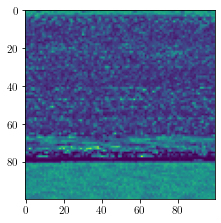

In [8]:
# Loading ORIGINAL dataset

original_data = %time pdfast.read_csv("original.csv")
print("Original dataset")

# Getting the distribution of the classes
meta = original_data.groupby(by='CLASS').apply(lambda x: len(x))
display(meta)

# plotting one image as example
img_sample(original_data.iloc[-1])

## Training MINOS with the original dataset

Fiting classifier 135 34


2022-08-09 14:31:29.270485: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 100, 100, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        1

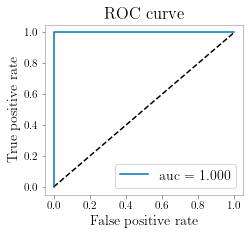

In [9]:
# We use the same split proposed in minos, 80-20
train, test = split(original_data, 0.8)


print("Fiting classifier", len(train), len(test))
minos = MINOS()
minos.fit(train, test, model_name="original23.h5")
test_labels = test["CLASS"]
predictions = minos.predict(test)
print(f"Accuracy: {accuracy(predictions, test_labels)}")
predictions_values = predictions.values

test_labels_bin = test_labels.apply(lambda x: MINOS.classes.index(x))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels_bin, predictions_values[:, 1])
auc_keras_val = auc_keras(fpr_keras, tpr_keras)

# Potting original roc 
plot_roc(fpr_keras, tpr_keras, auc_keras_val, f"ROC_ORIGINAL.pdf")

# Getting f score
# classes = minos.predict_classes(test, predictions)
# display(classes)
# print("F score", f_score(classes, test_labels))

## Getting augmented data and passing it to the original model


CPU times: user 3.55 s, sys: 3.06 s, total: 6.61 s
Wall time: 27.5 s
CPU times: user 3.24 s, sys: 2.28 s, total: 5.51 s
Wall time: 21.3 s
Augmented dataset


,Name,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,99_91,99_92,99_93,99_94,99_95,99_96,99_97,99_98,99_99,CLASS
0,augmented_benign_bfs/bening_basic4gl.wasm.1274...,0.160784,0.164706,0.164706,0.168627,0.168627,0.168627,0.168627,0.168627,0.164706,...,0.337255,0.325490,0.317647,0.301961,0.298039,0.313725,0.325490,0.313725,0.341176,BENIGN
1,augmented_benign_bfs/bening_micr.io.wasm.516.w...,0.282353,0.168627,0.250980,0.247059,0.211765,0.262745,0.219608,0.172549,0.258824,...,0.329412,0.454902,0.474510,0.305882,0.356863,0.435294,0.549020,0.341176,0.494118,BENIGN
2,augmented_benign_bfs/bening_jakedeichert.githu...,0.156863,0.168627,0.172549,0.164706,0.160784,0.172549,0.168627,0.176471,0.176471,...,0.227451,0.219608,0.235294,0.258824,0.227451,0.227451,0.341176,0.219608,0.168627,BENIGN
3,augmented_benign_bfs/bening_creaturepack-wasm....,0.168627,0.172549,0.172549,0.172549,0.172549,0.164706,0.160784,0.164706,0.164706,...,0.301961,0.286275,0.301961,0.301961,0.305882,0.286275,0.309804,0.317647,0.294118,BENIGN
4,augmented_benign_bfs/bening_ammo.wasm.wasm.145...,0.156863,0.164706,0.160784,0.160784,0.160784,0.164706,0.160784,0.160784,0.160784,...,0.317647,0.309804,0.294118,0.286275,0.278431,0.290196,0.321569,0.301961,0.321569,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,augmented_malign_bfs/malign_bluegrassrivals.co...,0.164706,0.164706,0.168627,0.172549,0.168627,0.168627,0.168627,0.168627,0.168627,...,0.513725,0.486275,0.407843,0.427451,0.478431,0.466667,0.450980,0.486275,0.482353,MALIGN
39996,augmented_malign_bfs/malign_justproxy.co.uk.wa...,0.168627,0.156863,0.176471,0.164706,0.180392,0.180392,0.172549,0.180392,0.180392,...,0.317647,0.400000,0.490196,0.490196,0.447059,0.380392,0.415686,0.454902,0.349020,MALIGN
39997,augmented_malign_bfs/malign_browsermine.com_c7...,0.160784,0.164706,0.168627,0.172549,0.168627,0.168627,0.168627,0.168627,0.168627,...,0.486275,0.470588,0.478431,0.498039,0.490196,0.482353,0.450980,0.494118,0.494118,MALIGN
39998,augmented_malign_bfs/malign_hevcbay.com_440f91...,0.184314,0.145098,0.180392,0.180392,0.176471,0.164706,0.184314,0.176471,0.192157,...,0.192157,0.192157,0.227451,0.184314,0.235294,0.282353,0.207843,0.223529,0.203922,MALIGN


(apply_list_of_funcs pid=6692) 


(apply_list_of_funcs pid=6696) 


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000
MALIGN,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000


(compute_sliced_len pid=6700) 


(apply_list_of_funcs pid=6702) 
(apply_list_of_funcs pid=6697) 
(apply_list_of_funcs pid=6695) 


(apply_list_of_funcs pid=6690) 
Accuracy: 0.508
Plotting plots/ROC.AUGNMENTED.BREAKING1.SIZE40000.pdf


(apply_func pid=6695) 


,index,Name,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,...,99_91,99_92,99_93,99_94,99_95,99_96,99_97,99_98,99_99,CLASS
0,0,augmented_benign_bfs/bening_basic4gl.wasm.1274...,0.160784,0.164706,0.164706,0.168627,0.168627,0.168627,0.168627,0.168627,...,0.337255,0.325490,0.317647,0.301961,0.298039,0.313725,0.325490,0.313725,0.341176,BENIGN
1,1,augmented_benign_bfs/bening_micr.io.wasm.516.w...,0.282353,0.168627,0.250980,0.247059,0.211765,0.262745,0.219608,0.172549,...,0.329412,0.454902,0.474510,0.305882,0.356863,0.435294,0.549020,0.341176,0.494118,BENIGN
2,2,augmented_benign_bfs/bening_jakedeichert.githu...,0.156863,0.168627,0.172549,0.164706,0.160784,0.172549,0.168627,0.176471,...,0.227451,0.219608,0.235294,0.258824,0.227451,0.227451,0.341176,0.219608,0.168627,BENIGN
3,3,augmented_benign_bfs/bening_creaturepack-wasm....,0.168627,0.172549,0.172549,0.172549,0.172549,0.164706,0.160784,0.164706,...,0.301961,0.286275,0.301961,0.301961,0.305882,0.286275,0.309804,0.317647,0.294118,BENIGN
4,4,augmented_benign_bfs/bening_ammo.wasm.wasm.145...,0.156863,0.164706,0.160784,0.160784,0.160784,0.164706,0.160784,0.160784,...,0.317647,0.309804,0.294118,0.286275,0.278431,0.290196,0.321569,0.301961,0.321569,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39995,augmented_malign_bfs/malign_bluegrassrivals.co...,0.164706,0.164706,0.168627,0.172549,0.168627,0.168627,0.168627,0.168627,...,0.513725,0.486275,0.407843,0.427451,0.478431,0.466667,0.450980,0.486275,0.482353,BENIGN
39996,39996,augmented_malign_bfs/malign_justproxy.co.uk.wa...,0.168627,0.156863,0.176471,0.164706,0.180392,0.180392,0.172549,0.180392,...,0.317647,0.400000,0.490196,0.490196,0.447059,0.380392,0.415686,0.454902,0.349020,BENIGN
39997,39997,augmented_malign_bfs/malign_browsermine.com_c7...,0.160784,0.164706,0.168627,0.172549,0.168627,0.168627,0.168627,0.168627,...,0.486275,0.470588,0.478431,0.498039,0.490196,0.482353,0.450980,0.494118,0.494118,BENIGN
39998,39998,augmented_malign_bfs/malign_hevcbay.com_440f91...,0.184314,0.145098,0.180392,0.180392,0.176471,0.164706,0.184314,0.176471,...,0.192157,0.192157,0.227451,0.184314,0.235294,0.282353,0.207843,0.223529,0.203922,BENIGN


(apply_list_of_funcs pid=6695) 
(apply_list_of_funcs pid=6700) 


(compute_sliced_len pid=6689) 
(compute_sliced_len pid=6831) 


(compute_sliced_len pid=6831) 


(compute_sliced_len pid=6833) 


(apply_list_of_funcs pid=6833) 
(compute_sliced_len pid=6689) 
(compute_sliced_len pid=6696) 
(compute_sliced_len pid=6690) 
(compute_sliced_len pid=6701) 
(compute_sliced_len pid=6834) 


(compute_sliced_len pid=6698) 


(apply_list_of_funcs pid=6833) 
(compute_sliced_len pid=6831) 


(compute_sliced_len pid=6703) 
(compute_sliced_len pid=6696) 


(compute_sliced_len pid=6696) 


(compute_sliced_len pid=6703) 


(compute_sliced_len pid=6832) 
(apply_list_of_funcs pid=6698) 


(compute_sliced_len pid=6699) 
(compute_sliced_len pid=6834) 
(compute_sliced_len pid=6700) 


(compute_sliced_len pid=6691) 
(compute_sliced_len pid=6703) 
(compute_sliced_len pid=6702) 
(compute_sliced_len pid=6693) 
(apply_list_of_funcs pid=6697) 
(compute_sliced_len pid=6834) 
(compute_sliced_len pid=6696) 


(compute_sliced_len pid=6692) 


(compute_sliced_len pid=6831) 
(compute_sliced_len pid=6693) 
(compute_sliced_len pid=6700) 


(compute_sliced_len pid=6832) 


(compute_sliced_len pid=6833) 
(compute_sliced_len pid=6690) 
(compute_sliced_len pid=6832) 


(compute_sliced_len pid=6694) 


(compute_sliced_len pid=6700) 
(compute_sliced_len pid=6833) 
(compute_sliced_len pid=6701) 
(compute_sliced_len pid=6696) 
(compute_sliced_len pid=6695) 


(compute_sliced_len pid=6697) 
(compute_sliced_len pid=6688) 


(compute_sliced_len pid=6701) 
(compute_sliced_len pid=6699) 


(compute_sliced_len pid=6696) 


(compute_sliced_len pid=6834) 
(apply_list_of_funcs pid=6692) 


(compute_sliced_len pid=6833) 


(compute_sliced_len pid=6694) 
(compute_sliced_len pid=6696) 


(compute_sliced_len pid=6696) 
(compute_sliced_len pid=6693) 


(compute_sliced_len pid=6692) 
(compute_sliced_len pid=6699) 
(compute_sliced_len pid=6701) 
(compute_sliced_len pid=6689) 


(compute_sliced_len pid=6696) 


(compute_sliced_len pid=6689) 
(compute_sliced_len pid=6688) 
(compute_sliced_len pid=6689) 


(compute_sliced_len pid=6689) 


(compute_sliced_len pid=6698) 
(compute_sliced_len pid=6693) 
(apply_list_of_funcs pid=6831) 
(compute_sliced_len pid=6832) 
(compute_sliced_len pid=6693) 


(compute_sliced_len pid=6693) 


(compute_sliced_len pid=6698) 
(compute_sliced_len pid=6698) 
(compute_sliced_len pid=6703) 
(compute_sliced_len pid=6697) 
(compute_sliced_len pid=6689) 


(compute_sliced_len pid=6692) 


(compute_sliced_len pid=6689) 
(compute_sliced_len pid=6691) 
(compute_sliced_len pid=6698) 


(apply_list_of_funcs pid=6692) 
(compute_sliced_len pid=6703) 


(compute_sliced_len pid=6699) 
(compute_sliced_len pid=6694) 
(compute_sliced_len pid=6698) 
(compute_sliced_len pid=6703) 


(apply_list_of_funcs pid=6691) 


(compute_sliced_len pid=6698) 
(compute_sliced_len pid=6834) 


(apply_list_of_funcs pid=6694) 


(compute_sliced_len pid=6832) 


(compute_sliced_len pid=6689) 


(compute_sliced_len pid=6831) 
(compute_sliced_len pid=6695) 


(compute_sliced_len pid=6831) 


(compute_sliced_len pid=6689) 


(compute_sliced_len pid=6833) 


(compute_sliced_len pid=6834) 
(compute_sliced_len pid=6699) 
(compute_sliced_len pid=6698) 
(compute_sliced_len pid=6691) 


(compute_sliced_len pid=6699) 


(compute_sliced_len pid=6695) 


(compute_sliced_len pid=6697) 


(compute_sliced_len pid=6703) 
(compute_sliced_len pid=6834) 
(compute_sliced_len pid=6832) 


(compute_sliced_len pid=6832) 
(compute_sliced_len pid=6693) 
(compute_sliced_len pid=6693) 
(compute_sliced_len pid=6832) 


(compute_sliced_len pid=6690) 


(compute_sliced_len pid=6690) 


(compute_sliced_len pid=6690) 
(compute_sliced_len pid=6832) 
(compute_sliced_len pid=6700) 


(compute_sliced_len pid=6703) 


(compute_sliced_len pid=6694) 


(compute_sliced_len pid=6694) 


(compute_sliced_len pid=6696) 
(compute_sliced_len pid=6695) 


(compute_sliced_len pid=6697) 


(compute_sliced_len pid=6702) 


(compute_sliced_len pid=6834) 


(compute_sliced_len pid=6690) 


(compute_sliced_len pid=6695) 
(compute_sliced_len pid=6693) 


(apply_list_of_funcs pid=6690) 


(compute_sliced_len pid=6688) 
(compute_sliced_len pid=6834) 
(compute_sliced_len pid=6695) 
(compute_sliced_len pid=6831) 


(compute_sliced_len pid=6692) 
(compute_sliced_len pid=6692) 
(compute_sliced_len pid=6690) 


(compute_sliced_len pid=6691) 


(compute_sliced_len pid=6698) 
(compute_sliced_len pid=6692) 
(compute_sliced_len pid=6833) 
(compute_sliced_len pid=6697) 
(compute_sliced_len pid=6696) 
(apply_list_of_funcs pid=6698) 
(compute_sliced_len pid=6703) 
(compute_sliced_len pid=6698) 
(compute_sliced_len pid=6694) 
(compute_sliced_len pid=6831) 


(compute_sliced_len pid=6690) 
(compute_sliced_len pid=6699) 


(compute_sliced_len pid=6834) 
(compute_sliced_len pid=6696) 
(compute_sliced_len pid=6699) 
(compute_sliced_len pid=6694) 


(compute_sliced_len pid=6701) 


(compute_sliced_len pid=6703) 


(compute_sliced_len pid=6697) 


368
F score 0.03605015673981191


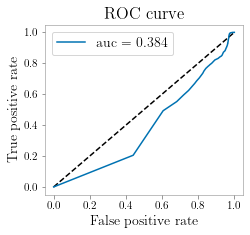

In [63]:
# The augmented dataset is massive, to be able to make the proof of concept we generated
# the datasets by using `shuf -n <SIZE> ...` to the original 36Gb collection to get a random 
# permutation of the complete dataset

# Comment out the datasets to load less or more data

# augmented_benign = %time pdfast.read_csv("augmented1_benign.1k.csv")
# augmented_malign = %time pdfast.read_csv("augmented1_malign.1k.csv")

# augmented_benign = %time pdfast.read_csv("augmented1_benign.2k.csv")
# augmented_malign = %time pdfast.read_csv("augmented1_malign.2k.csv")


# augmented_benign = %time pdfast.read_csv("augmented1_benign.5k.csv")
# augmented_malign = %time pdfast.read_csv("augmented1_malign.5k.csv")

augmented_benign = %time pdfast.read_csv("augmented1_benign.20k.csv")
augmented_malign = %time pdfast.read_csv("augmented1_malign.20k.csv")


augmented1 = pdfast.concat([augmented_benign, augmented_malign], axis=0, ignore_index=True)


print("Augmented dataset")
display(augmented1)
meta = augmented1.groupby(by='CLASS').apply(lambda x: len(x))
display(meta)

test_labels = augmented1["CLASS"]
predictions = minos.predict(augmented1)

print(f"Accuracy: {accuracy(predictions, test_labels)}")
predictions_values = predictions.values

test_labels_bin = test_labels.apply(lambda x: MINOS.classes.index(x))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels_bin, predictions_values[:, 1])
auc_keras_val = auc_keras(fpr_keras, tpr_keras)


# Potting roc 
plot_roc(fpr_keras, tpr_keras, auc_keras_val, f"ROC_AUGNMENTED_BREAKING1_SIZE{len(augmented1)}.pdf")


# Getting f score
classes = minos.predict_classes(augmented1, predictions)
display(classes)
print("F score", f_score(classes, test_labels))

augmented_benign_bfs/bening_creaturepack-wasm.wasm.7408.wasm.png BENIGN
Original
7    original/creaturepack-wasm.wasm.png
Name: Name, dtype: object 7    BENIGN
Name: CLASS, dtype: object


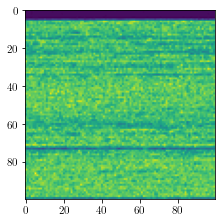

<Figure size 266.4x251.044 with 0 Axes>

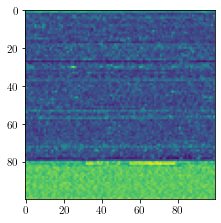

In [14]:
# after a lot of iterations
img_sample(augmented1.iloc[3])
plt.figure()

# original
original_data_again = pdfast.read_csv("original.csv")
pack = original_data_again[original_data_again['Name'] == 'original/creaturepack-wasm.wasm.png']

print("Original")
img_sample(pack)

## Step 2, training on augmented

(apply_func pid=6697) 


(apply_func pid=6703) 
Fiting classifier 32000 8000
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_21 (Reshape)        (None, 100, 100, 1)       0         
                                                                 
 conv2d_63 (Conv2D)          (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 49, 49, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 

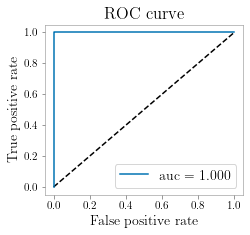

In [51]:
train, test = split(augmented1, 0.8)


print("Fiting classifier", len(train), len(test))
minos2 = MINOS()
minos2.fit(train, test, epochs=50, model_name="with_augmentation14.h5")
test_labels = test["CLASS"]
predictions = minos2.predict(test)
print(f"Accuracy: {accuracy(predictions, test_labels)}")
predictions = predictions.values

predictions = minos2.predict(test).values

test_labels = test_labels.apply(lambda x: MINOS.classes.index(x))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, predictions[:, 1])
auc_keras_val = auc_keras(fpr_keras, tpr_keras)

# Potting original roc 
plot_roc(fpr_keras, tpr_keras, auc_keras_val, f"ROC_AUGMENTED.pdf")


CPU times: user 596 ms, sys: 203 ms, total: 799 ms
Wall time: 1.5 s


(deploy_ray_func pid=6832) 


CPU times: user 599 ms, sys: 222 ms, total: 822 ms
Wall time: 1.57 s


,Name,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,99_91,99_92,99_93,99_94,99_95,99_96,99_97,99_98,99_99,CLASS
0,augmented_benign_bfs/bening_www.figma.com.wasm...,0.149020,0.172549,0.176471,0.164706,0.160784,0.172549,0.176471,0.176471,0.168627,...,0.239216,0.203922,0.203922,0.133333,0.180392,0.152941,0.149020,0.164706,0.192157,BENIGN
1,augmented_benign_bfs/bening_basic4gl.wasm.937....,0.176471,0.196078,0.188235,0.200000,0.188235,0.200000,0.180392,0.188235,0.196078,...,0.380392,0.329412,0.329412,0.376471,0.431373,0.419608,0.431373,0.419608,0.435294,BENIGN
2,augmented_benign_bfs/bening_developers.arcgis....,0.152941,0.156863,0.172549,0.172549,0.180392,0.180392,0.176471,0.180392,0.168627,...,0.384314,0.262745,0.352941,0.290196,0.305882,0.290196,0.278431,0.290196,0.235294,BENIGN
3,augmented_benign_bfs/bening_canvas.apps.chrome...,0.145098,0.149020,0.152941,0.149020,0.149020,0.145098,0.149020,0.149020,0.149020,...,0.301961,0.305882,0.301961,0.278431,0.266667,0.266667,0.262745,0.262745,0.274510,BENIGN
4,augmented_benign_bfs/bening_boyan.io5.wasm.980...,0.160784,0.164706,0.164706,0.164706,0.164706,0.164706,0.164706,0.164706,0.164706,...,0.203922,0.200000,0.207843,0.192157,0.188235,0.192157,0.200000,0.200000,0.196078,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,augmented_malign_bfs/malign_pharmatips.in.wasm...,0.160784,0.164706,0.164706,0.168627,0.168627,0.164706,0.164706,0.164706,0.164706,...,0.466667,0.384314,0.407843,0.341176,0.407843,0.407843,0.458824,0.450980,0.400000,MALIGN
1996,augmented_malign_bfs/malign_creative-solutions...,0.172549,0.168627,0.168627,0.168627,0.168627,0.172549,0.172549,0.172549,0.168627,...,0.517647,0.494118,0.462745,0.509804,0.458824,0.513725,0.470588,0.490196,0.454902,MALIGN
1997,augmented_malign_bfs/malign_tainiesonline.top....,0.160784,0.164706,0.168627,0.168627,0.168627,0.168627,0.164706,0.164706,0.164706,...,0.396078,0.400000,0.403922,0.396078,0.431373,0.427451,0.458824,0.411765,0.458824,MALIGN
1998,augmented_malign_bfs/malign_desirefx.me_12ee11...,0.156863,0.164706,0.172549,0.168627,0.172549,0.172549,0.172549,0.172549,0.176471,...,0.364706,0.356863,0.384314,0.396078,0.396078,0.349020,0.360784,0.305882,0.282353,MALIGN


Augmented dataset


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
MALIGN,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000


(apply_list_of_funcs pid=6689) 
Accuracy: 1.0
Plotting plots/ROC.AUGNMENTED.BREAKING1.VALIDATION.SIZE2000.pdf


,index,Name,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,...,99_91,99_92,99_93,99_94,99_95,99_96,99_97,99_98,99_99,CLASS
0,0,augmented_benign_bfs/bening_www.figma.com.wasm...,0.149020,0.172549,0.176471,0.164706,0.160784,0.172549,0.176471,0.176471,...,0.239216,0.203922,0.203922,0.133333,0.180392,0.152941,0.149020,0.164706,0.192157,BENIGN
1,1,augmented_benign_bfs/bening_basic4gl.wasm.937....,0.176471,0.196078,0.188235,0.200000,0.188235,0.200000,0.180392,0.188235,...,0.380392,0.329412,0.329412,0.376471,0.431373,0.419608,0.431373,0.419608,0.435294,BENIGN
2,2,augmented_benign_bfs/bening_developers.arcgis....,0.152941,0.156863,0.172549,0.172549,0.180392,0.180392,0.176471,0.180392,...,0.384314,0.262745,0.352941,0.290196,0.305882,0.290196,0.278431,0.290196,0.235294,BENIGN
3,3,augmented_benign_bfs/bening_canvas.apps.chrome...,0.145098,0.149020,0.152941,0.149020,0.149020,0.145098,0.149020,0.149020,...,0.301961,0.305882,0.301961,0.278431,0.266667,0.266667,0.262745,0.262745,0.274510,BENIGN
4,4,augmented_benign_bfs/bening_boyan.io5.wasm.980...,0.160784,0.164706,0.164706,0.164706,0.164706,0.164706,0.164706,0.164706,...,0.203922,0.200000,0.207843,0.192157,0.188235,0.192157,0.200000,0.200000,0.196078,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,augmented_malign_bfs/malign_pharmatips.in.wasm...,0.160784,0.164706,0.164706,0.168627,0.168627,0.164706,0.164706,0.164706,...,0.466667,0.384314,0.407843,0.341176,0.407843,0.407843,0.458824,0.450980,0.400000,MALIGN
1996,1996,augmented_malign_bfs/malign_creative-solutions...,0.172549,0.168627,0.168627,0.168627,0.168627,0.172549,0.172549,0.172549,...,0.517647,0.494118,0.462745,0.509804,0.458824,0.513725,0.470588,0.490196,0.454902,MALIGN
1997,1997,augmented_malign_bfs/malign_tainiesonline.top....,0.160784,0.164706,0.168627,0.168627,0.168627,0.168627,0.164706,0.164706,...,0.396078,0.400000,0.403922,0.396078,0.431373,0.427451,0.458824,0.411765,0.458824,MALIGN
1998,1998,augmented_malign_bfs/malign_desirefx.me_12ee11...,0.156863,0.164706,0.172549,0.168627,0.172549,0.172549,0.172549,0.172549,...,0.364706,0.356863,0.384314,0.396078,0.396078,0.349020,0.360784,0.305882,0.282353,MALIGN


(apply_list_of_funcs pid=6699) 


(compute_sliced_len pid=6695) 
(compute_sliced_len pid=6693) 
F score 1.0


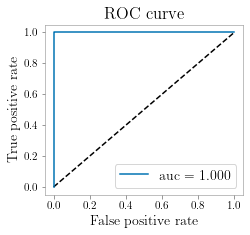

In [57]:
# Validating that the model learned this distribution


augmented_benign1 = %time pdfast.read_csv("augmented1_benign.1k.csv")
augmented_malign1 = %time pdfast.read_csv("augmented1_malign.1k.csv")


augmented11 = pdfast.concat([augmented_benign1, augmented_malign1], axis=0, ignore_index=True)

display(augmented11)

print("Augmented dataset")
meta = augmented11.groupby(by='CLASS').apply(lambda x: len(x))
display(meta)

test_labels = augmented11["CLASS"]
predictions = minos2.predict(augmented11)

print(f"Accuracy: {accuracy(predictions, test_labels)}")
predictions_values = predictions.values

test_labels_bin = test_labels.apply(lambda x: MINOS.classes.index(x))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels_bin, predictions_values[:, 1])
auc_keras_val = auc_keras(fpr_keras, tpr_keras)


# Potting roc 
plot_roc(fpr_keras, tpr_keras, auc_keras_val, f"ROC_AUGNMENTED_BREAKING1_VALIDATION_SIZE{len(augmented11)}.pdf")


# Getting f score
classes = minos.predict_classes(augmented11, predictions)
display(classes)
print("F score", f_score(classes, test_labels))

## Step 3

Try with another distribution on the augmented model

If the model learns the obfuscation on AUGMENTED1, what happens when the obfuscation follows another distribution ?

CPU times: user 5.04 s, sys: 4.3 s, total: 9.34 s
Wall time: 44.9 s
CPU times: user 6.05 s, sys: 4.81 s, total: 10.9 s
Wall time: 52.8 s


,Name,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,99_91,99_92,99_93,99_94,99_95,99_96,99_97,99_98,99_99,CLASS
0,augmented_benign_bfs_5k_100_1234/bening_svg_as...,0.360784,0.188235,0.298039,0.380392,0.356863,0.376471,0.321569,0.325490,0.329412,...,0.184314,0.129412,0.062745,0.070588,0.113725,0.027451,0.086275,0.196078,0.039216,BENIGN
1,4/bening_wasm_astar.wasm.5.wasm.png,0.305882,0.278431,0.184314,0.184314,0.109804,0.266667,0.313725,0.294118,0.270588,...,0.133333,0.125490,0.141176,0.121569,0.098039,0.149020,0.235294,0.109804,0.184314,BENIGN
2,augmented_benign_bfs_5k_100_1234/bening_usindi...,0.000000,0.000000,0.000000,0.105882,0.247059,0.360784,0.427451,0.466667,0.486275,...,0.117647,0.058824,0.000000,0.000000,0.000000,0.054902,0.101961,0.129412,0.141176,BENIGN
3,augmented_benign_bfs_5k_100_1234/bening_wasm_a...,0.274510,0.243137,0.172549,0.188235,0.105882,0.250980,0.305882,0.294118,0.266667,...,0.078431,0.141176,0.125490,0.086275,0.145098,0.129412,0.062745,0.086275,0.117647,BENIGN
4,augmented_benign_bfs_5k_100_1234/bening_hebjem...,0.000000,0.000000,0.003922,0.062745,0.141176,0.231373,0.321569,0.384314,0.427451,...,0.309804,0.160784,0.082353,0.043137,0.023529,0.015686,0.011765,0.003922,0.000000,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,augmented_malign_bfs_5k_100_1234/malign_webmin...,0.160784,0.168627,0.164706,0.168627,0.172549,0.168627,0.168627,0.168627,0.168627,...,0.478431,0.447059,0.501961,0.462745,0.490196,0.450980,0.407843,0.474510,0.486275,MALIGN
19996,augmented_malign_bfs_5k_100_1234/malign_worker...,0.160784,0.164706,0.168627,0.164706,0.164706,0.164706,0.164706,0.164706,0.164706,...,0.450980,0.450980,0.458824,0.454902,0.450980,0.470588,0.450980,0.435294,0.447059,MALIGN
19997,augmented_malign_bfs_5k_100_1234/malign_webmin...,0.160784,0.168627,0.164706,0.168627,0.172549,0.168627,0.168627,0.168627,0.168627,...,0.466667,0.474510,0.486275,0.509804,0.466667,0.458824,0.498039,0.458824,0.498039,MALIGN
19998,augmented_malign_bfs_5k_100_1234/malign_uzhasn...,0.160784,0.164706,0.168627,0.164706,0.164706,0.164706,0.164706,0.164706,0.164706,...,0.376471,0.376471,0.443137,0.427451,0.407843,0.427451,0.439216,0.458824,0.470588,MALIGN


Augmented dataset 2


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
MALIGN,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000


Accuracy: 0.55945
Plotting plots/ROC.AUGNMENTED.BREAKING2.SIZE20000.pdf


,index,Name,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,...,99_91,99_92,99_93,99_94,99_95,99_96,99_97,99_98,99_99,CLASS
0,0,augmented_benign_bfs_5k_100_1234/bening_svg_as...,0.360784,0.188235,0.298039,0.380392,0.356863,0.376471,0.321569,0.325490,...,0.184314,0.129412,0.062745,0.070588,0.113725,0.027451,0.086275,0.196078,0.039216,BENIGN
1,1,4/bening_wasm_astar.wasm.5.wasm.png,0.305882,0.278431,0.184314,0.184314,0.109804,0.266667,0.313725,0.294118,...,0.133333,0.125490,0.141176,0.121569,0.098039,0.149020,0.235294,0.109804,0.184314,MALIGN
2,2,augmented_benign_bfs_5k_100_1234/bening_usindi...,0.000000,0.000000,0.000000,0.105882,0.247059,0.360784,0.427451,0.466667,...,0.117647,0.058824,0.000000,0.000000,0.000000,0.054902,0.101961,0.129412,0.141176,BENIGN
3,3,augmented_benign_bfs_5k_100_1234/bening_wasm_a...,0.274510,0.243137,0.172549,0.188235,0.105882,0.250980,0.305882,0.294118,...,0.078431,0.141176,0.125490,0.086275,0.145098,0.129412,0.062745,0.086275,0.117647,MALIGN
4,4,augmented_benign_bfs_5k_100_1234/bening_hebjem...,0.000000,0.000000,0.003922,0.062745,0.141176,0.231373,0.321569,0.384314,...,0.309804,0.160784,0.082353,0.043137,0.023529,0.015686,0.011765,0.003922,0.000000,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,augmented_malign_bfs_5k_100_1234/malign_webmin...,0.160784,0.168627,0.164706,0.168627,0.172549,0.168627,0.168627,0.168627,...,0.478431,0.447059,0.501961,0.462745,0.490196,0.450980,0.407843,0.474510,0.486275,MALIGN
19996,19996,augmented_malign_bfs_5k_100_1234/malign_worker...,0.160784,0.164706,0.168627,0.164706,0.164706,0.164706,0.164706,0.164706,...,0.450980,0.450980,0.458824,0.454902,0.450980,0.470588,0.450980,0.435294,0.447059,BENIGN
19997,19997,augmented_malign_bfs_5k_100_1234/malign_webmin...,0.160784,0.168627,0.164706,0.168627,0.172549,0.168627,0.168627,0.168627,...,0.466667,0.474510,0.486275,0.509804,0.466667,0.458824,0.498039,0.458824,0.498039,MALIGN
19998,19998,augmented_malign_bfs_5k_100_1234/malign_uzhasn...,0.160784,0.164706,0.168627,0.164706,0.164706,0.164706,0.164706,0.164706,...,0.376471,0.376471,0.443137,0.427451,0.407843,0.427451,0.439216,0.458824,0.470588,BENIGN


(apply_list_of_funcs pid=6693) 


(compute_sliced_len pid=6832) 
(compute_sliced_len pid=6700) 


(compute_sliced_len pid=6832) 


(compute_sliced_len pid=6701) 


(compute_sliced_len pid=6692) 


(compute_sliced_len pid=6702) 
(compute_sliced_len pid=6832) 
(compute_sliced_len pid=6698) 
(compute_sliced_len pid=6690) 
(compute_sliced_len pid=6697) 
(compute_sliced_len pid=6693) 


(compute_sliced_len pid=6692) 


(compute_sliced_len pid=6696) 
(compute_sliced_len pid=6832) 
(compute_sliced_len pid=6696) 


(compute_sliced_len pid=6695) 


(compute_sliced_len pid=6703) 
(compute_sliced_len pid=6696) 
(compute_sliced_len pid=6699) 
(compute_sliced_len pid=6702) 
(apply_list_of_funcs pid=6701) 


(compute_sliced_len pid=6831) 


(compute_sliced_len pid=6703) 


(apply_list_of_funcs pid=6695) 


(compute_sliced_len pid=6692) 
(compute_sliced_len pid=6693) 


(compute_sliced_len pid=6700) 


(compute_sliced_len pid=6694) 
(compute_sliced_len pid=6832) 
(apply_list_of_funcs pid=6696) 


(compute_sliced_len pid=6692) 
(compute_sliced_len pid=6697) 
(compute_sliced_len pid=6700) 
(compute_sliced_len pid=6693) 
(compute_sliced_len pid=6702) 


(compute_sliced_len pid=6832) 
(compute_sliced_len pid=6700) 
(compute_sliced_len pid=6695) 
(compute_sliced_len pid=6701) 


(compute_sliced_len pid=6697) 


(compute_sliced_len pid=6699) 


(compute_sliced_len pid=6688) 
(apply_list_of_funcs pid=6833) 
(compute_sliced_len pid=6688) 
(compute_sliced_len pid=6700) 


(apply_list_of_funcs pid=6693) 
(compute_sliced_len pid=6701) 
(compute_sliced_len pid=6696) 


(compute_sliced_len pid=6831) 


(compute_sliced_len pid=6699) 


(compute_sliced_len pid=6699) 


(compute_sliced_len pid=6688) 
(compute_sliced_len pid=6692) 


(compute_sliced_len pid=6697) 
(compute_sliced_len pid=6691) 


(compute_sliced_len pid=6696) 


(compute_sliced_len pid=6696) 
(compute_sliced_len pid=6691) 
(compute_sliced_len pid=6699) 
(compute_sliced_len pid=6832) 


(compute_sliced_len pid=6693) 
(compute_sliced_len pid=6831) 
(compute_sliced_len pid=6697) 


(compute_sliced_len pid=6693) 


(compute_sliced_len pid=6701) 
(compute_sliced_len pid=6697) 


(compute_sliced_len pid=6693) 


(compute_sliced_len pid=6831) 


(compute_sliced_len pid=6833) 
(compute_sliced_len pid=6695) 


(compute_sliced_len pid=6694) 
(compute_sliced_len pid=6688) 
F score 0.4437148809899615


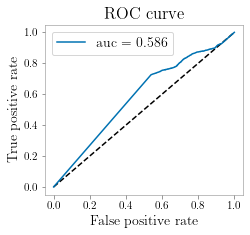

In [58]:
augmented_benign3 = %time pdfast.read_csv("augmented2_benign.csv")
augmented_malign3 = %time pdfast.read_csv("augmented2_malign.csv")


# Set the classes to the same representation
# comment out to use the original one
augmented_benign3 = augmented_benign3.iloc[:10000]
augmented_malign3 = augmented_malign3.iloc[:10000]
augmented3 = pdfast.concat([augmented_benign3, augmented_malign3], axis=0, ignore_index=True)

display(augmented3)

print("Augmented dataset 2")
meta = augmented3.groupby(by='CLASS').apply(lambda x: len(x))
display(meta)

test_labels = augmented3["CLASS"]
predictions = minos2.predict(augmented3)

print(f"Accuracy: {accuracy(predictions, test_labels)}")
predictions_values = predictions.values

test_labels_bin = test_labels.apply(lambda x: MINOS.classes.index(x))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels_bin, predictions_values[:, 1])
auc_keras_val = auc_keras(fpr_keras, tpr_keras)


# Potting roc 
plot_roc(fpr_keras, tpr_keras, auc_keras_val, f"ROC_AUGNMENTED_BREAKING2_SIZE{len(augmented3)}.pdf")


# Getting f score
classes = minos.predict_classes(augmented3, predictions)
display(classes)
print("F score", f_score(classes, test_labels))

**The report stops here.**

## Step 3.5 (Appendix)
One idea could be to train the model with more data. If the resulting auc with a larger trainig set is not monotonically "linear", to train with a larger dataset is worthless. 

In [18]:
! unzip -p datasets.zip augmented1_benign.20k.csv > augmented1_benign.20k.csv
! unzip -p datasets.zip augmented1_malign.20k.csv > augmented1_malign.20k.csv
! unzip -p datasets.zip augmented1_benign.1k.csv > augmented1_benign.1k.csv
! unzip -p datasets.zip augmented1_malign.1k.csv > augmented1_malign.1k.csv
! unzip -p datasets.zip augmented1_benign.2k.csv > augmented1_benign.2k.csv
! unzip -p datasets.zip augmented1_malign.2k.csv > augmented1_malign.2k.csv
! unzip -p datasets.zip augmented1_benign.5k.csv > augmented1_benign.5k.csv
! unzip -p datasets.zip augmented1_malign.5k.csv > augmented1_malign.5k.csv
! unzip -p datasets.zip augmented1_benign.10k.csv > augmented1_benign.10k.csv
! unzip -p datasets.zip augmented1_malign.10k.csv > augmented1_malign.10k.csv
! unzip -p datasets.zip augmented1_malign.50k.csv > augmented1_malign.50k.csv
! unzip -p datasets.zip augmented1_benign.50k.csv > augmented1_benign.50k.csv
! unzip -p datasets.zip augmented1_benign.100k.csv > augmented1_benign.100k.csv
! unzip -p datasets.zip augmented1_malign.100k.csv > augmented1_malign.100k.csv

In [ ]:
! unzip -p datasets.zip by_mutators/fix_chunk.py > fix_chunk.py
! python3 fix_chunk.py augmented1_benign.100k.csv
! python3 fix_chunk.py augmented1_malign.100k.csv

In [ ]:
# Load the datasets first
datasets = [
    ("augmented1_benign.1k.csv","augmented1_malign.1k.csv", 2000),
    ("augmented1_benign.2k.csv","augmented1_malign.2k.csv", 4000),
    ("augmented1_benign.5k.csv", "augmented1_malign.5k.csv", 10000),
    ("augmented1_benign.10k.csv", "augmented1_malign.10k.csv", 20000),
    ("augmented1_benign.20k.csv", "augmented1_malign.20k.csv", 40000),
    ("augmented1_benign.50k.csv", "augmented1_malign.50k.csv", 100000),
    ("augmented1_benign.100k.csv", "augmented1_malign.100k.csv", 200000)
]

frames = []

for benignname, malignname,size in datasets:
    print(size)
    augmented_benign = %time pdfast.read_csv(benignname)
    augmented_malign = %time pdfast.read_csv(malignname)
    
    augmented = pdfast.concat([augmented_benign, augmented_malign], axis=0, ignore_index=True)
    frames.append((augmented, size))

2000
CPU times: user 597 ms, sys: 210 ms, total: 807 ms
Wall time: 1.85 s
CPU times: user 579 ms, sys: 164 ms, total: 744 ms
Wall time: 1.54 s
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 100, 100, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                       

(apply_list_of_funcs pid=6093) 


Accuracy on distribution 2: 0.56365
[(0.6943676349999999, 2000, 0.0847470760345459), (0.704556845, 4000, 0.08704423904418945), (0.716180985, 10000, 0.15767931938171387)]
Plotting plots/ROC.DISTRIB2.10000.pdf
20000
CPU times: user 1.79 s, sys: 1.04 s, total: 2.83 s
Wall time: 8.59 s
CPU times: user 2.05 s, sys: 1.88 s, total: 3.93 s
Wall time: 10.9 s


(apply_list_of_funcs pid=6098) 


(apply_list_of_funcs pid=6102) 
(apply_list_of_funcs pid=6093) 
(apply_list_of_funcs pid=6089) 


(apply_list_of_funcs pid=6095) 


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 100, 100, 1)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 49, 49, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 21, 21, 64)       

(deploy_ray_func pid=6090) 


(apply_list_of_funcs pid=6095) 
(apply_list_of_funcs pid=6140) 


(apply_list_of_funcs pid=6093) 


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 100, 100, 1)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 49, 49, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 21, 21, 64)       

(apply_list_of_funcs pid=6140) 
(apply_list_of_funcs pid=6097) 


(apply_list_of_funcs pid=6103) 
(apply_list_of_funcs pid=6101) 
(apply_list_of_funcs pid=6103) 


(apply_list_of_funcs pid=6093) 
(apply_list_of_funcs pid=6089) 
(apply_list_of_funcs pid=6089) 


(apply_list_of_funcs pid=6096) 
(apply_list_of_funcs pid=6093) 


(deploy_ray_func pid=6101) 
(deploy_ray_func pid=6094) 


(deploy_ray_func pid=6098) 


(deploy_ray_func pid=6098) 
(deploy_ray_func pid=6091) 


(deploy_ray_func pid=6089) 
(deploy_ray_func pid=6100) 
(apply_list_of_funcs pid=6095) 
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_7 (Reshape)         (None, 100, 100, 1)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 49, 49, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                

(apply_list_of_funcs pid=6099) 


(apply_list_of_funcs pid=6091) 
(apply_list_of_funcs pid=6093) 


(apply_list_of_funcs pid=6091) 
(apply_list_of_funcs pid=6093) 
(apply_list_of_funcs pid=6101) 
(apply_list_of_funcs pid=6091) 


(apply_list_of_funcs pid=6093) 
(apply_list_of_funcs pid=6103) 
(apply_list_of_funcs pid=6097) 


(apply_list_of_funcs pid=6093) 


Epoch 1/50
3094/3094 [==============================] - 198s 64ms/step - loss: 0.0929 - accuracy: 0.9634 - val_loss: 0.0019 - val_accuracy: 0.9990
Epoch 2/50
3094/3094 [==============================] - 181s 59ms/step - loss: 0.0137 - accuracy: 0.9969 - val_loss: 0.0044 - val_accuracy: 0.9980
Epoch 3/50
3094/3094 [==============================] - 185s 60ms/step - loss: 0.0159 - accuracy: 0.9979 - val_loss: 2.7921e-05 - val_accuracy: 1.0000
Epoch 4/50
3094/3094 [==============================] - 190s 62ms/step - loss: 0.0088 - accuracy: 0.9984 - val_loss: 0.0011 - val_accuracy: 0.9990
Epoch 5/50
3094/3094 [==============================] - 173s 56ms/step - loss: 0.0104 - accuracy: 0.9985 - val_loss: 0.0023 - val_accuracy: 0.9990
Epoch 6/50
3094/3094 [==============================] - 178s 58ms/step - loss: 0.0088 - accuracy: 0.9987 - val_loss: 0.0050 - val_accuracy: 0.9990
Epoch 7/50
3094/3094 [==============================] - 180s 58ms/step - loss: 0.0093 - accuracy: 0.9987 - val_los

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/javierca/Documents/Develop/ralph/ralph/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/gq/b9tbk2vx1qg57m7c4rkrdzv40000gn/T/ipykernel_5311/1595461739.py", line 23, in <module>
    minos2.fit(train, test, epochs=50, model_name=f"with_augmentation_size{size}.1.h5")
  File "/var/folders/gq/b9tbk2vx1qg57m7c4rkrdzv40000gn/T/ipykernel_5311/3135786541.py", line 116, in fit
    history = self.model.fit(X_train, Y_train, validation_data=(X_test, Y_test), callbacks=[checkpointer], epochs=epochs)
  File "/Users/javierca/Documents/Develop/ralph/ralph/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "/Users/javierca/Documents/Develop/ralph/ralph/lib/python3.9/site-packages/keras/engine/training.py", line 1216, in fit
    tmp_logs = self.train_function(iterator)
  F

TypeError: object of type 'NoneType' has no len()

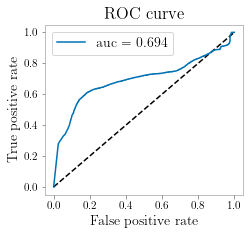

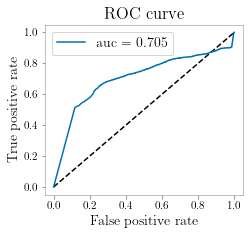

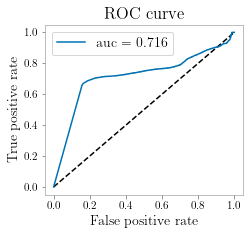

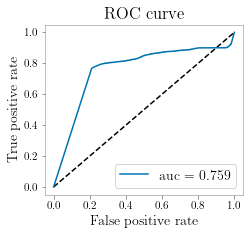

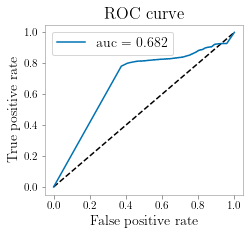

In [19]:
# Collect the rewards by dataset size
values = []
for augmented,size in frames:
    print(size)
    train, test = split(augmented, 0.99)
    
    minos2 = MINOS()
    t0 = time.time()
    minos2.fit(train, test, epochs=50, model_name=f"with_augmentation_size{size}.1.h5")
    t0 = time.time() - t0
    
    # Comparing the other distribution
    test_labels = augmented3["CLASS"]
    predictions = minos2.predict(augmented3)
    
    acc = accuracy(predictions, test_labels)
    print(f"Acc {acc}")
    predictions_values = predictions.values

    test_labels = test_labels.apply(lambda x: MINOS.classes.index(x))
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, predictions_values[:, 1])
    auc_keras_val = auc_keras(fpr_keras, tpr_keras)
    
    # Saving the auc, the size of the dataset and the training time
    values.append((auc_keras_val, size, t0, acc))
    print(values)
    plot_roc(fpr_keras, tpr_keras, auc_keras_val, f"ROC_DISTRIB2_{size}.pdf")

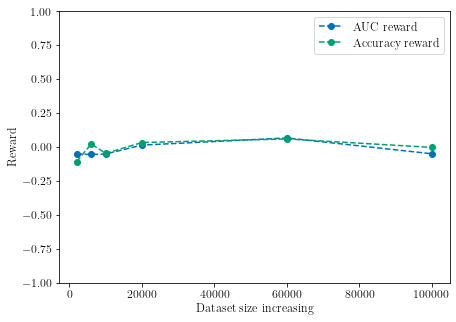

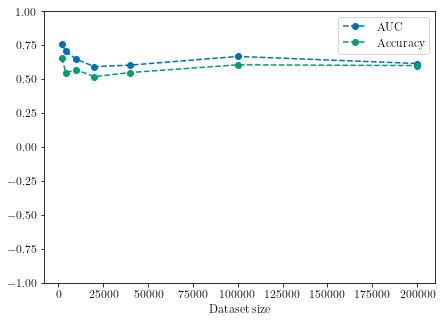

In [109]:
latexify(fig_width=7, fig_height=5)
diffs = list(zip(values, values[1:]))

Xs = [ nxt[1] - curr[1] for (curr, nxt) in diffs ]
AUCs = [ nxt[0] - curr[0] for (curr, nxt) in diffs ]
ACCs = [ nxt[3] - curr[3] for (curr, nxt) in diffs ]


plt.figure()
plt.plot(Xs, AUCs, '--o', label="AUC reward")
plt.plot(Xs, ACCs, '--o', label="Accuracy reward")
plt.ylim(-1, 1)
plt.xlabel("Dataset size increasing")
plt.ylabel("Reward")
plt.legend()
plt.savefig("plots/auc_reward.pdf")


Xs = [ v[1] for v in values ]
AUCs = [ v[0] for v in values ]
ACCs = [ v[3] for v in values ]


plt.figure()
plt.plot(Xs, AUCs, '--o', label="AUC")
plt.plot(Xs,ACCs, '--o', label="Accuracy")
plt.ylim(-1, 1)
plt.xlabel("Dataset size")
plt.legend()
plt.savefig("plots/aucs_vs_dataset_size.pdf")
